# Проект для «Викишоп» c BERT и TF-IDF

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

#### Загрузка библиотек

In [1]:
!pip install transformers
!pip install optuna
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 8.3 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 6.6 MB 40.8 MB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.3 MB/s 
     |████████████████████████████████| 81 kB 7.9 MB/s 
     |████████████████████████████████| 210 kB 42.0 MB/s 
     |████████████████████████████████| 78 kB 3.7 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 112 kB 43.3 MB/s 
     |████████████████████████████████| 146 kB 40.0 MB/s 
  Created wheel for pyper

In [2]:
import time
import numpy as np
from numpy.random import RandomState
import pandas as pd
import torch
import transformers as ppb
from tqdm import notebook
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline 
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

#### Загрузка датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
try:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    toxic_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv')

In [4]:
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Дубликатов нет

In [ ]:
toxic_comments.duplicated().sum()

0

Баланс классов в целевом признаке (0 - нетоксичный текст, 1 - токсичный) на всем датасете

In [ ]:
toxic_comments['toxic'].value_counts(normalize=True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Так как весь датасет внушительного объема, для колибровки метода BERT возмем случайный батч из датасета установленного размера

In [5]:
state = RandomState(12345)

In [6]:
batch_1 = toxic_comments.sample(100_000, random_state=12345).reset_index(drop=True) 

Баланс классов в сэмпле

In [ ]:
batch_1['toxic'].value_counts(normalize=True)

0    0.89797
1    0.10203
Name: toxic, dtype: float64

In [ ]:
del toxic_comments

Загрузка DistilBERT - облегченной версии BERT, более быстродейственной и не менее эффективной

In [7]:
# DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [ ]:
# BERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [8]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Токенизация сэмпла датасета с добавленем нулей и маскированием важности. Количество токенов будем ограничивать, так как этот фактор сильно влияет на время обработки, и модель не поддерживает их количество больше 512

In [9]:
%%time

# tokenizer = ppb.BertTokenizer(
#     vocab_file='/datasets/ds_bert/vocab.txt')

tokenized = batch_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, 
                                                              truncation=True,
                                                              max_length=512)))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

CPU times: user 3min 7s, sys: 986 ms, total: 3min 8s
Wall time: 3min 21s


In [ ]:
np.array(padded).shape

(100000, 512)

In [ ]:
attention_mask.shape

(100000, 512)

In [ ]:
padded

array([[  101,  6289,  2232, ...,     0,     0,     0],
       [  101,  1000,  7514, ...,     0,     0,     0],
       [  101,  7514,  4931, ...,     0,     0,     0],
       ...,
       [  101,  2459,  1024, ...,     0,     0,     0],
       [  101,  1000,  2092, ...,     0,     0,     0],
       [  101, 26261, 22943, ...,     0,     0,     0]])

## Обучение

### Применение величин, полученных нейросетью BERT, как признаков для определения тональности 

Получение эмбеддингов с разбиеним на батчи для контроля процесса обработки с использыванием GPU при возможности 

In [10]:
%%time

batch_size = 100
embeddings = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device) # закидываем тензор на GPU
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            model.to(device) # модель тоже
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())  # перевод обратно на проц, чтобы в нумпай кинуть

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 28min 44s, sys: 3.59 s, total: 28min 48s
Wall time: 28min 54s


In [11]:
features = np.concatenate(embeddings)

In [ ]:
%%time
# обучаем и тестируем модель

X_train, X_test, y_train, y_test = train_test_split(features, batch_1['toxic'], test_size=0.2)
lr = LogisticRegression(random_state=state).fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('F1 на кроссвалидации:', cross_val_score(lr, X_train, y_train, cv=4, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.737655546821977
F1 на тестовой: 0.7387289516567083
CPU times: user 1min 26s, sys: 6.62 s, total: 1min 32s
Wall time: 47.7 s


Подбор моделей для BERT

In [ ]:
state = RandomState(12345)

In [ ]:
%%time

models = [DecisionTreeClassifier(random_state=state), 
          RandomForestClassifier(random_state=state),
          LogisticRegression(),
          GaussianNB(),
          LinearSVC()]

results_cross_val = []

for model in notebook.tqdm(models): 
    start_time = time.time()
    cv_score = cross_val_score(model, X_train, y_train, cv=4, scoring='f1').mean()    
    elapsed_time = time.time() - start_time
    results_cross_val.append({'model_name': model.__class__.__name__, 
                              'cv_score': '%.2f' % cv_score,
                              'learn_time': '%.2f' % elapsed_time})

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 33min 37s, sys: 5.09 s, total: 33min 42s
Wall time: 33min 11s


In [ ]:
pd.DataFrame(results_cross_val).sort_values('cv_score')

,model_name,cv_score,learn_time
0,DecisionTreeClassifier,0.50,756.92
3,GaussianNB,0.54,1.93
1,RandomForestClassifier,0.58,920.18
2,LogisticRegression,0.74,28.34
4,LinearSVC,0.74,283.61


Подбор гиперпараметров модели Catboost Classifier с помощью Optuna

In [ ]:
%%time

import optuna

def run_cb(trial):
    
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cb_model = CatBoostClassifier(**param)
    
    cb_model.fit(
        X_train,
        y_train,
        early_stopping_rounds=100,
        eval_set=[(X_test, y_test)],
        verbose=1000)
    
    y_test_pred = cb_model.predict(X_test)
    
    score = f1_score(y_test, y_test_pred)
    print('F1 score of CatBoost =', score)
    return score

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.8 µs


In [ ]:
%%time

study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=0), study_name='Catboost Optuna')
study.optimize(run_cb, n_trials=20, n_jobs=-1)

[I 2022-05-24 07:50:46,989] A new study created in memory with name: Catboost Optuna


Learning rate set to 0.093535
0:	learn: 0.5850886	test: 0.5851681	best: 0.5851681 (0)	total: 117ms	remaining: 1m 57s
Learning rate set to 0.093535
0:	learn: 0.5953148	test: 0.5954133	best: 0.5954133 (0)	total: 143ms	remaining: 2m 23s
999:	learn: 0.1000987	test: 0.1315159	best: 0.1314934 (988)	total: 43.6s	remaining: 0us

bestTest = 0.131493426
bestIteration = 988

Shrink model to first 989 iterations.


[I 2022-05-24 07:51:49,606] Trial 0 finished with value: 0.7176209005002778 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.030836177654361474, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.5438940134544389}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.7176209005002778
0:	learn: 0.6560867	test: 0.6563729	best: 0.6563729 (0)	total: 487ms	remaining: 8m 6s
999:	learn: 0.1297967	test: 0.1426838	best: 0.1426790 (997)	total: 2m 34s	remaining: 0us

bestTest = 0.1426790029
bestIteration = 997

Shrink model to first 998 iterations.


[I 2022-05-24 07:53:42,106] Trial 1 finished with value: 0.6908778953388618 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.022329016887374025, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.877359590227162}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.6908778953388618
0:	learn: 0.6522157	test: 0.6524125	best: 0.6524125 (0)	total: 422ms	remaining: 7m 1s
999:	learn: 0.0932742	test: 0.1407365	best: 0.1407365 (999)	total: 7m 5s	remaining: 0us

bestTest = 0.1407365337
bestIteration = 999



[I 2022-05-24 07:59:11,945] Trial 2 finished with value: 0.6885341074020319 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07472022551522044, 'depth': 9, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.001845470286304}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.6885341074020319
0:	learn: 0.6552323	test: 0.6553838	best: 0.6553838 (0)	total: 335ms	remaining: 5m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1358904637
bestIteration = 641

Shrink model to first 642 iterations.


[I 2022-05-24 07:59:50,746] Trial 3 finished with value: 0.6991963260619976 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08463138654492626, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7311906964209869}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.6991963260619976
0:	learn: 0.6524045	test: 0.6526133	best: 0.6526133 (0)	total: 185ms	remaining: 3m 5s
999:	learn: 0.1245039	test: 0.1407275	best: 0.1407275 (999)	total: 2m 59s	remaining: 0us

bestTest = 0.1407274967
bestIteration = 999



[I 2022-05-24 08:03:06,534] Trial 5 finished with value: 0.6892008020624463 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.08117295418534909, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.865964187591441}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.6892008020624463
0:	learn: 0.6534647	test: 0.6535255	best: 0.6535255 (0)	total: 674ms	remaining: 11m 13s
999:	learn: 0.1224352	test: 0.1362093	best: 0.1362036 (998)	total: 4m 7s	remaining: 0us

bestTest = 0.1362036034
bestIteration = 998

Shrink model to first 999 iterations.


[I 2022-05-24 08:03:36,900] Trial 4 finished with value: 0.7066069428891377 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07354101775992969, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.77374519098503}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.7066069428891377
Learning rate set to 0.093535
0:	learn: 0.5818935	test: 0.5815677	best: 0.5815677 (0)	total: 220ms	remaining: 3m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1337692178
bestIteration = 800

Shrink model to first 801 iterations.


[I 2022-05-24 08:06:40,478] Trial 7 finished with value: 0.7104160848924881 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09312867124001915, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.16532871903123078}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.7104160848924881
0:	learn: 0.6553836	test: 0.6555189	best: 0.6555189 (0)	total: 182ms	remaining: 3m 1s
999:	learn: 0.1217770	test: 0.1438297	best: 0.1438297 (999)	total: 2m 38s	remaining: 0us

bestTest = 0.1438296748
bestIteration = 999



[I 2022-05-24 08:09:36,230] Trial 8 finished with value: 0.6806526806526807 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03767033534092839, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.066678492228153}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.6806526806526807
Learning rate set to 0.093535
0:	learn: 0.5779999	test: 0.5784378	best: 0.5784378 (0)	total: 158ms	remaining: 2m 37s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1355473409
bestIteration = 443

Shrink model to first 444 iterations.


[I 2022-05-24 08:11:27,719] Trial 9 finished with value: 0.7054176072234764 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04466840742176683, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.2727848426505863}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.7054176072234764
0:	learn: 0.6548314	test: 0.6550338	best: 0.6550338 (0)	total: 1.34s	remaining: 22m 21s
999:	learn: 0.0956578	test: 0.1325183	best: 0.1325183 (999)	total: 11m 5s	remaining: 0us

bestTest = 0.1325183013
bestIteration = 999



[I 2022-05-24 08:14:29,212] Trial 6 finished with value: 0.709731543624161 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09005455740158197, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9908025407391637}. Best is trial 0 with value: 0.7176209005002778.


F1 score of CatBoost = 0.709731543624161
Learning rate set to 0.093535
0:	learn: 0.5960261	test: 0.5959014	best: 0.5959014 (0)	total: 256ms	remaining: 4m 15s
999:	learn: 0.0877005	test: 0.1309204	best: 0.1309204 (999)	total: 3m 39s	remaining: 0us

bestTest = 0.1309204158
bestIteration = 999



[I 2022-05-24 08:18:28,016] Trial 11 finished with value: 0.7232267037552156 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.01812998196426887, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7232267037552156
Learning rate set to 0.093535
0:	learn: 0.5875798	test: 0.5876687	best: 0.5876687 (0)	total: 239ms	remaining: 3m 59s
999:	learn: 0.0899309	test: 0.1302891	best: 0.1302015 (974)	total: 3m 11s	remaining: 0us

bestTest = 0.1302015272
bestIteration = 974

Shrink model to first 975 iterations.


[I 2022-05-24 08:21:58,070] Trial 12 finished with value: 0.7195767195767195 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.012212720813429005, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7195767195767195
Learning rate set to 0.093535
0:	learn: 0.5941732	test: 0.5944495	best: 0.5944495 (0)	total: 152ms	remaining: 2m 31s
999:	learn: 0.0901014	test: 0.1313235	best: 0.1312691 (985)	total: 3m 8s	remaining: 0us

bestTest = 0.1312691276
bestIteration = 985

Shrink model to first 986 iterations.


[I 2022-05-24 08:25:24,940] Trial 13 finished with value: 0.7162274618585298 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011511864851752127, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7162274618585298
Learning rate set to 0.093535
0:	learn: 0.5922653	test: 0.5925383	best: 0.5925383 (0)	total: 188ms	remaining: 3m 8s
999:	learn: 0.0906983	test: 0.1305864	best: 0.1305188 (981)	total: 3m 3s	remaining: 0us

bestTest = 0.130518829
bestIteration = 981

Shrink model to first 982 iterations.


[I 2022-05-24 08:28:47,278] Trial 14 finished with value: 0.7225626740947075 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.010149606241038191, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7225626740947075
Learning rate set to 0.093535
0:	learn: 0.5772184	test: 0.5779221	best: 0.5779221 (0)	total: 353ms	remaining: 5m 52s
999:	learn: 0.0870203	test: 0.1405805	best: 0.1405805 (999)	total: 17m 41s	remaining: 0us

bestTest = 0.1405804837
bestIteration = 999



[I 2022-05-24 08:29:27,101] Trial 10 finished with value: 0.681260945709282 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.025031515822713367, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.08133260789174}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.681260945709282
Learning rate set to 0.093535
0:	learn: 0.5878586	test: 0.5882788	best: 0.5882788 (0)	total: 360ms	remaining: 5m 59s
999:	learn: 0.0804082	test: 0.1327067	best: 0.1325556 (963)	total: 5m 12s	remaining: 0us

bestTest = 0.132555592
bestIteration = 963

Shrink model to first 964 iterations.


[I 2022-05-24 08:34:17,760] Trial 15 finished with value: 0.71298090229726 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05613899846658739, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.71298090229726
Learning rate set to 0.093535
0:	learn: 0.5870668	test: 0.5872729	best: 0.5872729 (0)	total: 312ms	remaining: 5m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.1313612914
bestIteration = 758

Shrink model to first 759 iterations.


[I 2022-05-24 08:34:44,325] Trial 16 finished with value: 0.7152022315202232 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.057265749161539516, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7152022315202232
Learning rate set to 0.093535
0:	learn: 0.5826595	test: 0.5824999	best: 0.5824999 (0)	total: 190ms	remaining: 3m 9s
999:	learn: 0.0873280	test: 0.1306092	best: 0.1305058 (904)	total: 3m 16s	remaining: 0us

bestTest = 0.1305057878
bestIteration = 904

Shrink model to first 905 iterations.


[I 2022-05-24 08:38:17,153] Trial 18 finished with value: 0.7179058758006127 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.019481007456781302, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7179058758006127
Learning rate set to 0.093535
0:	learn: 0.5877307	test: 0.5884233	best: 0.5884233 (0)	total: 274ms	remaining: 4m 33s
999:	learn: 0.0834414	test: 0.1311443	best: 0.1311443 (999)	total: 4m 59s	remaining: 0us

bestTest = 0.1311442979
bestIteration = 999



[I 2022-05-24 08:39:33,726] Trial 17 finished with value: 0.7196675900277009 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05561472238657764, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 11 with value: 0.7232267037552156.


F1 score of CatBoost = 0.7196675900277009
999:	learn: 0.0835983	test: 0.1298310	best: 0.1298310 (999)	total: 2m 51s	remaining: 0us

bestTest = 0.1298309898
bestIteration = 999



[I 2022-05-24 08:41:24,396] Trial 19 finished with value: 0.7234629170113042 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04328043478034295, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 19 with value: 0.7234629170113042.


F1 score of CatBoost = 0.7234629170113042
CPU times: user 1h 31min, sys: 8min 9s, total: 1h 39min 10s
Wall time: 50min 37s


Подбор гиперпараметров модели LogisticRegression с помощью Optuna

In [ ]:
%%time

import optuna

def run_lr(trial):
    
    param = {
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 10, 500, 20),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
    }


    lr_model = LogisticRegression(**param, 
                                  n_jobs=-1, verbose=1000).fit(X_train, y_train)
    
    y_test_pred = lr_model.predict(X_test)
    score = f1_score(y_test, y_test_pred)
    print('F1 score of LogisticRegression =', score)
    return score

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.3 µs


In [ ]:
%%time

study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='LogisticRegression Optuna')
study.optimize(run_lr, n_trials=50, n_jobs=-1)

[I 2022-05-24 10:18:01,050] A new study created in memory with name: LogisticRegression Optuna


[LibLinear][Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 10:18:42,511] Trial 0 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 90, 'l1_ratio': 0.5189996947448272}. Best is trial 0 with value: 0.7449062754686226.


F1 score of LogisticRegression = 0.7449062754686226
[LibLinear]

[I 2022-05-24 10:19:25,921] Trial 2 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 190, 'l1_ratio': 0.19052071083418498}. Best is trial 0 with value: 0.7449062754686226.


F1 score of LogisticRegression = 0.7449062754686226
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 10:22:40,667] Trial 1 finished with value: 0.7439455782312926 and parameters: {'solver': 'saga', 'max_iter': 190, 'l1_ratio': 0.5939282438280775}. Best is trial 0 with value: 0.7449062754686226.


max_iter reached after 279 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.7min finished
F1 score of LogisticRegression = 0.7439455782312926
[LibLinear]

[I 2022-05-24 10:23:47,953] Trial 4 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 30, 'l1_ratio': 0.7961533856956682}. Best is trial 0 with value: 0.7449062754686226.


F1 score of LogisticRegression = 0.7449062754686226
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 10:23:54,719] Trial 5 finished with value: 0.7010656197420079 and parameters: {'solver': 'newton-cg', 'max_iter': 10, 'l1_ratio': 0.9167318678384468}. Best is trial 0 with value: 0.7449062754686226.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.5s finished
F1 score of LogisticRegression = 0.7010656197420079
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 10:25:52,459] Trial 6 finished with value: 0.7445652173913043 and parameters: {'solver': 'newton-cg', 'max_iter': 310, 'l1_ratio': 0.7828923105719224}. Best is trial 0 with value: 0.7449062754686226.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished
F1 score of LogisticRegression = 0.7445652173913043
[LibLinear]

[I 2022-05-24 10:26:58,840] Trial 7 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 430, 'l1_ratio': 0.6723281211168333}. Best is trial 0 with value: 0.7449062754686226.


F1 score of LogisticRegression = 0.7449062754686226
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 10:28:56,995] Trial 8 finished with value: 0.7445652173913043 and parameters: {'solver': 'newton-cg', 'max_iter': 350, 'l1_ratio': 0.8443852799106688}. Best is trial 0 with value: 0.7449062754686226.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished
F1 score of LogisticRegression = 0.7445652173913043
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 10:29:02,938] Trial 9 finished with value: 0.7010656197420079 and parameters: {'solver': 'newton-cg', 'max_iter': 10, 'l1_ratio': 0.07199207427573218}. Best is trial 0 with value: 0.7449062754686226.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.6s finished
F1 score of LogisticRegression = 0.7010656197420079
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.0min finished


[I 2022-05-24 10:35:05,609] Trial 10 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.020421928089051855}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.9min finished


[I 2022-05-24 10:35:19,669] Trial 3 finished with value: 0.7455878360032581 and parameters: {'solver': 'lbfgs', 'max_iter': 470, 'l1_ratio': 0.928795074799135}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7455878360032581
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.9min finished


[I 2022-05-24 10:41:01,015] Trial 11 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.34857870484701964}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.9min finished


[I 2022-05-24 10:46:52,733] Trial 13 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.339374622608997}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 19.0min finished


[I 2022-05-24 10:54:18,200] Trial 12 finished with value: 0.7455878360032581 and parameters: {'solver': 'lbfgs', 'max_iter': 490, 'l1_ratio': 0.34025560168615787}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7455878360032581
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 10:55:53,525] Trial 14 finished with value: 0.7438196142352623 and parameters: {'solver': 'lbfgs', 'max_iter': 250, 'l1_ratio': 0.007867628926613524}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.0min finished
F1 score of LogisticRegression = 0.7438196142352623
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 10:56:17,668] Trial 15 finished with value: 0.7449810092240912 and parameters: {'solver': 'sag', 'max_iter': 110, 'l1_ratio': 0.00046263736675024314}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 119 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished
F1 score of LogisticRegression = 0.7449810092240912
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 10:57:52,695] Trial 16 finished with value: 0.7449810092240912 and parameters: {'solver': 'sag', 'max_iter': 110, 'l1_ratio': 0.35429517593646687}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 119 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished
F1 score of LogisticRegression = 0.7449810092240912
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.0min finished


[I 2022-05-24 11:06:18,590] Trial 17 finished with value: 0.7452471482889734 and parameters: {'solver': 'lbfgs', 'max_iter': 270, 'l1_ratio': 0.33548205153384897}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7452471482889734
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 11:06:49,824] Trial 18 finished with value: 0.7453754080522306 and parameters: {'solver': 'lbfgs', 'max_iter': 230, 'l1_ratio': 0.3499848153451227}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.9min finished
F1 score of LogisticRegression = 0.7453754080522306
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 11:08:17,878] Trial 20 finished with value: 0.744553376906318 and parameters: {'solver': 'saga', 'max_iter': 70, 'l1_ratio': 0.21341012874551446}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 88 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.5min finished
F1 score of LogisticRegression = 0.744553376906318
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 11:11:14,244] Trial 19 finished with value: 0.7432616389872041 and parameters: {'solver': 'saga', 'max_iter': 210, 'l1_ratio': 0.22408643346377985}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 296 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.9min finished
F1 score of LogisticRegression = 0.7432616389872041
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.0min finished


[I 2022-05-24 11:13:19,383] Trial 21 finished with value: 0.7442489851150202 and parameters: {'solver': 'lbfgs', 'max_iter': 170, 'l1_ratio': 0.16480441762801173}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7442489851150202
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.0min finished


[I 2022-05-24 11:17:14,610] Trial 22 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.44858771511812345}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.5min finished


[I 2022-05-24 11:18:49,668] Trial 23 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.4128706138860498}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.9min finished


[I 2022-05-24 11:23:11,707] Trial 24 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.4540550737518653}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 11:23:31,452] Trial 25 finished with value: 0.7450662341173291 and parameters: {'solver': 'lbfgs', 'max_iter': 130, 'l1_ratio': 0.49208435583492866}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.7min finished
F1 score of LogisticRegression = 0.7450662341173291
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 11:24:27,105] Trial 27 finished with value: 0.7456521739130435 and parameters: {'solver': 'sag', 'max_iter': 50, 'l1_ratio': 0.44142333139391926}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 55 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.3s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   55.3s finished
F1 score of LogisticRegression = 0.7456521739130435
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 11:24:43,917] Trial 26 finished with value: 0.7277657266811279 and parameters: {'solver': 'lbfgs', 'max_iter': 50, 'l1_ratio': 0.4805753134083931}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.5min finished
F1 score of LogisticRegression = 0.7277657266811279
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.3min finished


[I 2022-05-24 11:34:45,586] Trial 28 finished with value: 0.7457903313416622 and parameters: {'solver': 'lbfgs', 'max_iter': 290, 'l1_ratio': 0.6315513298638287}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7457903313416622
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 11.1min finished


[I 2022-05-24 11:35:50,283] Trial 29 finished with value: 0.7457903313416622 and parameters: {'solver': 'lbfgs', 'max_iter': 290, 'l1_ratio': 0.5724326808980456}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7457903313416622
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.2min finished
F1 score of LogisticRegression = 0.7376425855513309


[I 2022-05-24 11:37:59,049] Trial 30 finished with value: 0.7376425855513309 and parameters: {'solver': 'lbfgs', 'max_iter': 90, 'l1_ratio': 0.5638379786257374}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 11:39:13,034] Trial 31 finished with value: 0.7376425855513309 and parameters: {'solver': 'lbfgs', 'max_iter': 90, 'l1_ratio': 0.4219330688188875}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.4min finished
F1 score of LogisticRegression = 0.7376425855513309
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.5min finished


[I 2022-05-24 11:43:29,500] Trial 32 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.42686115306827266}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 11:45:24,813] Trial 33 finished with value: 0.7439090416892258 and parameters: {'solver': 'lbfgs', 'max_iter': 190, 'l1_ratio': 0.7030584511340447}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.2min finished
F1 score of LogisticRegression = 0.7439090416892258
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 11:47:50,745] Trial 34 finished with value: 0.7439455782312926 and parameters: {'solver': 'saga', 'max_iter': 190, 'l1_ratio': 0.422439921629721}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 261 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.4min finished
F1 score of LogisticRegression = 0.7439455782312926
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 11:49:42,939] Trial 35 finished with value: 0.743603701687534 and parameters: {'solver': 'saga', 'max_iter': 190, 'l1_ratio': 0.2767226393895563}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 258 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.3min finished
F1 score of LogisticRegression = 0.743603701687534
[LibLinear]

[I 2022-05-24 11:50:50,214] Trial 37 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 130, 'l1_ratio': 0.5193047995058583}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7449062754686226
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  7.6min finished


[I 2022-05-24 11:55:25,105] Trial 36 finished with value: 0.7453754080522306 and parameters: {'solver': 'lbfgs', 'max_iter': 230, 'l1_ratio': 0.2670092434711271}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7453754080522306
[LibLinear]

[I 2022-05-24 11:56:35,701] Trial 39 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 350, 'l1_ratio': 0.12108805940043788}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7449062754686226
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  8.0min finished


[I 2022-05-24 11:58:49,285] Trial 38 finished with value: 0.7453754080522306 and parameters: {'solver': 'lbfgs', 'max_iter': 230, 'l1_ratio': 0.26912450125130477}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7453754080522306
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 12:00:49,678] Trial 41 finished with value: 0.7445652173913043 and parameters: {'solver': 'newton-cg', 'max_iter': 170, 'l1_ratio': 0.10693096992928956}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished
F1 score of LogisticRegression = 0.7445652173913043
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.2min finished


[I 2022-05-24 12:02:50,298] Trial 40 finished with value: 0.7442489851150202 and parameters: {'solver': 'lbfgs', 'max_iter': 170, 'l1_ratio': 0.39644562251489074}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7442489851150202
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  5.5min finished


[I 2022-05-24 12:06:18,741] Trial 42 finished with value: 0.7463175122749591 and parameters: {'solver': 'lbfgs', 'max_iter': 150, 'l1_ratio': 0.3775342960226306}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7463175122749591
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.9min finished


[I 2022-05-24 12:07:47,149] Trial 43 finished with value: 0.7450662341173291 and parameters: {'solver': 'lbfgs', 'max_iter': 130, 'l1_ratio': 0.514963776605522}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7450662341173291
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.9min finished


[I 2022-05-24 12:10:11,328] Trial 44 finished with value: 0.741001353179973 and parameters: {'solver': 'lbfgs', 'max_iter': 110, 'l1_ratio': 0.5373157972327551}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.741001353179973
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.6min finished


[I 2022-05-24 12:11:22,757] Trial 45 finished with value: 0.741001353179973 and parameters: {'solver': 'lbfgs', 'max_iter': 110, 'l1_ratio': 0.3120077784179457}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.741001353179973
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


[I 2022-05-24 12:12:31,167] Trial 47 finished with value: 0.7432138979370251 and parameters: {'solver': 'sag', 'max_iter': 70, 'l1_ratio': 0.6188196821040044}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 69 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished
F1 score of LogisticRegression = 0.7432138979370251
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[I 2022-05-24 12:13:39,589] Trial 48 finished with value: 0.7445652173913043 and parameters: {'solver': 'newton-cg', 'max_iter': 210, 'l1_ratio': 0.7218790081052432}. Best is trial 10 with value: 0.7463175122749591.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished
F1 score of LogisticRegression = 0.7445652173913043
[LibLinear]

[I 2022-05-24 12:13:58,792] Trial 46 finished with value: 0.7445770065075922 and parameters: {'solver': 'sag', 'max_iter': 210, 'l1_ratio': 0.6247073936047975}. Best is trial 10 with value: 0.7463175122749591.


max_iter reached after 227 seconds
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.8min finished
F1 score of LogisticRegression = 0.7445770065075922


[I 2022-05-24 12:14:16,458] Trial 49 finished with value: 0.7449062754686226 and parameters: {'solver': 'liblinear', 'max_iter': 410, 'l1_ratio': 0.4724745164222023}. Best is trial 10 with value: 0.7463175122749591.


F1 score of LogisticRegression = 0.7449062754686226
CPU times: user 35min 42s, sys: 20.4 s, total: 36min 2s
Wall time: 1h 56min 15s


In [ ]:
study.best_params

{'l1_ratio': 0.020421928089051855, 'max_iter': 150, 'solver': 'lbfgs'}

In [ ]:
%%time
# обучаем и тестируем модель LogisticRegression с лучшими гиперпараметрами

X_train, X_test, y_train, y_test = train_test_split(features, batch_1['toxic'], test_size=0.2, random_state=state)
lr = LogisticRegression(**study.best_params).fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('F1 на кроссвалидации:', cross_val_score(lr, X_train, y_train, cv=4, scoring='f1'))
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: [0.73859601 0.73195021 0.7373847  0.75123018]
F1 на тестовой: 0.7363050483351237
CPU times: user 1min 45s, sys: 7.82 s, total: 1min 52s
Wall time: 58 s


In [ ]:
%%time
# обучаем и тестируем модель

X_train, X_test, y_train, y_test = train_test_split(features, batch_1['toxic'], test_size=0.2, random_state=state)
lr = LogisticRegression(solver='sag', max_iter=500).fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('F1 на кроссвалидации:', cross_val_score(lr, X_train, y_train, cv=4, scoring='f1'))
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: [0.74203214 0.73913043 0.72702181 0.73675587]
F1 на тестовой: 0.7450980392156862
CPU times: user 20min 14s, sys: 1.57 s, total: 20min 15s
Wall time: 20min 17s


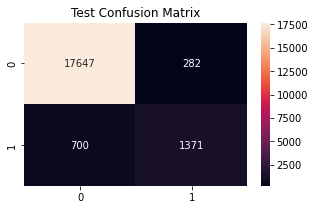

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
proba_one_X_test = lr.predict_proba(X_test)[:,1]

treshold_best, f1_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):

  y_pred = proba_one_X_test > treshold
  f1 = f1_score(y_test, y_pred)

  if f1 > f1_best:

    f1_best = f1
    treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('F1 при подборе порога:', f1_best)

Оптимальный порог классификации: 0.34
F1 при подборе порога: 0.7518283764017553


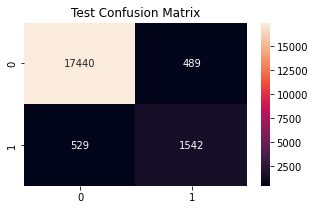

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = proba_one_X_test > treshold_best
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [12]:
%%time

import optuna

def run_svc(trial):
    
    param = {
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'max_iter': trial.suggest_int('max_iter', 1000, 3000, 100),
        'dual': trial.suggest_categorical('dual', [True, False]),
        'C': trial.suggest_float('C', 1.0, 100.0),
    }

    if param["dual"] == True:
        param["penalty"] = 'l2'
        param["loss"] ='hinge'
    elif param["dual"] == False:
        param["penalty"] = 'l1'
        param["loss"] = 'squared_hinge'

    svc_model = LinearSVC(**param).fit(X_train, y_train)
    
    y_test_pred = svc_model.predict(X_test)
    score = f1_score(y_test, y_test_pred)
    print('F1 score of LinearSVC =', score)
    return score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CPU times: user 536 ms, sys: 33 ms, total: 569 ms
Wall time: 783 ms


In [13]:
%%time

X_train, X_test, y_train, y_test = train_test_split(features, batch_1['toxic'], test_size=0.2)
study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='Linear Support Vector Classification Optuna')
study.optimize(run_svc, n_trials=20, n_jobs=-1)

[I 2022-05-24 17:22:58,100] A new study created in memory with name: Linear Support Vector Classification Optuna
[I 2022-05-24 17:31:36,162] Trial 1 finished with value: 0.7498749374687343 and parameters: {'class_weight': None, 'max_iter': 2600, 'dual': True, 'C': 86.53270305173095}. Best is trial 1 with value: 0.7498749374687343.


F1 score of LinearSVC = 0.7498749374687343


[I 2022-05-24 17:36:02,653] Trial 2 finished with value: 0.7466927976482116 and parameters: {'class_weight': 'balanced', 'max_iter': 1300, 'dual': True, 'C': 12.6996183149219}. Best is trial 1 with value: 0.7498749374687343.


F1 score of LinearSVC = 0.7466927976482116


[I 2022-05-24 18:09:21,211] Trial 0 finished with value: 0.6819866567828021 and parameters: {'class_weight': 'balanced', 'max_iter': 2600, 'dual': False, 'C': 17.23035164770069}. Best is trial 1 with value: 0.7498749374687343.


F1 score of LinearSVC = 0.6819866567828021


[I 2022-05-24 18:13:39,834] Trial 3 finished with value: 0.744686723709633 and parameters: {'class_weight': None, 'max_iter': 3000, 'dual': False, 'C': 70.82619242372158}. Best is trial 1 with value: 0.7498749374687343.


F1 score of LinearSVC = 0.744686723709633


[I 2022-05-24 18:14:39,253] Trial 4 finished with value: 0.7482211275314723 and parameters: {'class_weight': 'balanced', 'max_iter': 1500, 'dual': True, 'C': 36.06833411832954}. Best is trial 1 with value: 0.7498749374687343.


F1 score of LinearSVC = 0.7482211275314723


[I 2022-05-24 18:20:40,333] Trial 6 finished with value: 0.7556447566482689 and parameters: {'class_weight': 'balanced', 'max_iter': 1700, 'dual': True, 'C': 91.55815734341233}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7556447566482689


[I 2022-05-24 18:22:42,154] Trial 5 finished with value: 0.7361306674176289 and parameters: {'class_weight': 'balanced', 'max_iter': 2700, 'dual': True, 'C': 70.14885617635359}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7361306674176289


[I 2022-05-24 18:31:10,136] Trial 8 finished with value: 0.7168037602820212 and parameters: {'class_weight': 'balanced', 'max_iter': 2600, 'dual': True, 'C': 82.32949685549202}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7168037602820212


[I 2022-05-24 18:48:46,782] Trial 9 finished with value: 0.682501391723882 and parameters: {'class_weight': 'balanced', 'max_iter': 1000, 'dual': False, 'C': 12.93372053294293}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.682501391723882


[I 2022-05-24 18:55:51,316] Trial 10 finished with value: 0.6772388059701492 and parameters: {'class_weight': 'balanced', 'max_iter': 2100, 'dual': True, 'C': 75.00692455329369}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.6772388059701492


[I 2022-05-24 19:03:38,171] Trial 7 finished with value: 0.6831077322455035 and parameters: {'class_weight': 'balanced', 'max_iter': 2400, 'dual': False, 'C': 22.609599217606654}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.6831077322455035


[I 2022-05-24 19:10:01,626] Trial 12 finished with value: 0.7355742296918768 and parameters: {'class_weight': None, 'max_iter': 1800, 'dual': True, 'C': 95.93265664895979}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7355742296918768


[I 2022-05-24 19:17:20,192] Trial 13 finished with value: 0.5271063771678275 and parameters: {'class_weight': None, 'max_iter': 2100, 'dual': True, 'C': 99.23369156335059}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.5271063771678275


[I 2022-05-24 19:19:52,008] Trial 11 finished with value: 0.7458563535911601 and parameters: {'class_weight': None, 'max_iter': 1900, 'dual': False, 'C': 96.7322193955206}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7458563535911601


[I 2022-05-24 19:23:23,080] Trial 14 finished with value: 0.6310858290112096 and parameters: {'class_weight': None, 'max_iter': 1700, 'dual': True, 'C': 55.22144884013085}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.6310858290112096


[I 2022-05-24 19:25:37,097] Trial 15 finished with value: 0.48029465930018417 and parameters: {'class_weight': None, 'max_iter': 1600, 'dual': True, 'C': 54.67844314252746}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.48029465930018417


[I 2022-05-24 19:31:30,582] Trial 16 finished with value: 0.5757264957264957 and parameters: {'class_weight': None, 'max_iter': 2300, 'dual': True, 'C': 58.92824782245123}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.5757264957264957


[I 2022-05-24 19:33:38,565] Trial 17 finished with value: 0.7516778523489932 and parameters: {'class_weight': None, 'max_iter': 2300, 'dual': True, 'C': 83.98936901324758}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7516778523489932


[I 2022-05-24 19:38:20,209] Trial 19 finished with value: 0.7542242703533025 and parameters: {'class_weight': None, 'max_iter': 1300, 'dual': True, 'C': 35.69238454721838}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.7542242703533025


[I 2022-05-24 19:40:34,365] Trial 18 finished with value: 0.6888346552776083 and parameters: {'class_weight': None, 'max_iter': 3000, 'dual': True, 'C': 84.45838599458054}. Best is trial 6 with value: 0.7556447566482689.


F1 score of LinearSVC = 0.6888346552776083
CPU times: user 4h 29min 19s, sys: 14.1 s, total: 4h 29min 33s
Wall time: 2h 17min 36s


In [14]:
study.best_params

{'C': 91.55815734341233,
 'class_weight': 'balanced',
 'dual': True,
 'max_iter': 1700}

In [15]:
study.best_value

0.7556447566482689

In [26]:
best_params_1 = {'C': 300,
 'class_weight': None,
 'dual': False,
 'max_iter': 2000}

In [16]:
%%time
# обучаем и тестируем модель LinearSVC 

svc = LinearSVC(**study.best_params, random_state=state).fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('F1 на кроссвалидации:', cross_val_score(svc, X_train, y_train, cv=4, scoring='f1'))
print('F1 на тестовой:', f1_score(y_test, y_pred))

Accuracy: 0.8906125
F1 на тестовой: 0.6368866328257191
CPU times: user 4min 10s, sys: 277 ms, total: 4min 10s
Wall time: 4min 9s


In [28]:
%%time
# обучаем и тестируем модель LinearSVC 

svc = LinearSVC(**best_params_1, random_state=state).fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('F1 на кроссвалидации:', cross_val_score(svc, X_train, y_train, cv=4, scoring='f1'))
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: [0.72807746 0.72928789 0.73244887 0.7423194 ]
F1 на тестовой: 0.7458654906284454
CPU times: user 1min 23s, sys: 935 ms, total: 1min 24s
Wall time: 1min 24s


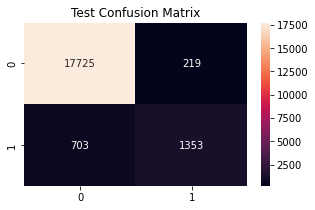

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [31]:
pd.DataFrame({'model_name': ['CatBoost Classifier', 'Linear SVC', 'Logistic Regression'], 
              'f1_score': [0.723, 0.746, 0.752]})

,model_name,f1_score
0,CatBoost Classifier,0.723
1,Linear SVC,0.746
2,Logistic Regression,0.752


### Применение техник TF-IDF и "мешка слов" с биграммами и без для извлечения признаков с целью определения тональности теста

Сэмпл датасета

In [ ]:
try:
    toxic_comments = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
except:
    toxic_comments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/toxic_comments.csv')

In [ ]:
batch_1 = toxic_comments.sample(80_000, random_state=12345).reset_index(drop=True) 
batch_1['toxic'].value_counts(normalize=True)

0    0.898475
1    0.101525
Name: toxic, dtype: float64

In [ ]:
del toxic_comments

In [ ]:
batch_1

,text,toxic,lemm_text
0,Ahh shut the fuck up you douchebag sand nigger...,1,ahh shut the fuck up you douchebag sand nigger...
1,"""\n\nREPLY: There is no such thing as Texas Co...",0,reply there be no such thing a texas commerce ...
2,"Reply\nHey, you could at least mention Jasenov...",0,reply hey you could at least mention jasenovac...
3,"Thats fine, there is no deadline ) chi?",0,thats fine there be no deadline chi
4,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0,dyk nomination of mustarabim hello your submis...
...,...,...,...
79995,nor he might be accountable for any editorial ...,0,nor he might be accountable for any editorial ...
79996,deletion: List of airports capable of accommod...,0,deletion list of airport capable of accommodat...
79997,The article still does not meet the standards ...,0,the article still do not meet the standard of ...
79998,"Sure, yet one of the points that kept coming u...",0,sure yet one of the point that kept come up wi...


Функция сопоставления входного символа, который принимает WordnetLemmatizer, POS-тегу 
и передачи его в качестве второго аргумента в lemmatize()

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Функция очистки и лемматизации текста лемматизатором WordNet

In [ ]:
# Инициализация лемматизатора Lemmatizer

lemmatizer = WordNetLemmatizer()

def text_lemmatize(text):
    text = re.sub(re.compile('<.*?>'), '', text) # очистка текста от html тэгов
    text = re.sub(r'[^a-zA-Z]', ' ', text) # очистка текста от всех лишних знаков
    text = text.lower() # приведение к нижнему регистру
    text = text.split() # разбиение на слова с удалением лишних пробелов
    text = ' '.join(text) # соединение слов в текст
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)] # лемматизация слов с POS-тэгами
    lemm_text = ' '.join(lemm_list) # соединение лемм в текст
    return lemm_text

Лемматизация текста с соответсвующими POS-тегами

In [ ]:
%%time

batch_1['lemm_text'] = batch_1['text'].apply(text_lemmatize)
batch_1.head()

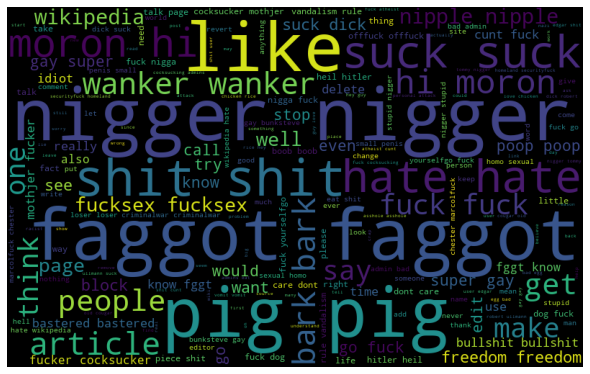

In [ ]:
from wordcloud import WordCloud

words_list = batch_1[batch_1['toxic']==1]['lemm_text'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height=500,            
                  stopwords=stopwords).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

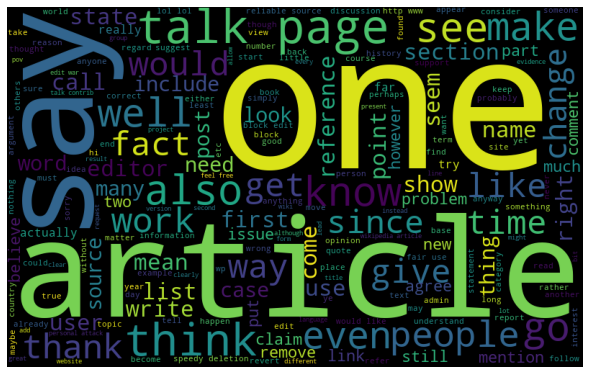

In [ ]:
from wordcloud import WordCloud

words_list = batch_1[batch_1['toxic']==0]['lemm_text'].unique().tolist()
pos_words = " ".join(words_list)

pos_wordcloud =  WordCloud(
                  width=800, height=500,            
                  stopwords=stopwords).generate(pos_words)

plt.figure(figsize=(8, 8), facecolor = None)
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Разделение на обучающую и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(batch_1['lemm_text'], batch_1['toxic'], test_size=0.2)

In [ ]:
corpus = X_train.values
corpus_test = X_test.values

Создание мешка слов методом CountVectorizer

In [ ]:
nltk.download('stopwords')

# создание мешка слов без учёта стоп-слов
count_vect = CountVectorizer() 
bow_train = count_vect.fit_transform(corpus)

print("Размер мешка без учёта стоп-слов:", bow_train.shape)

# создание нового мешка слов с учётом стоп-слов
stopwords = set(nltk_stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stopwords) 
bow_train = count_vect.fit_transform(corpus)
bow_test = count_vect.transform(corpus_test)

print("Размер мешка с учётом стоп-слов:", bow_train.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Размер мешка без учёта стоп-слов: (120000, 127697)
Размер мешка с учётом стоп-слов: (120000, 127563)


Создание N_gramm

In [ ]:
# corpus = list(toxic_comments['lemm_text'])
count_vect = CountVectorizer(ngram_range=(2, 2)) 
n_gramm_train = count_vect.fit_transform(corpus)
n_gramm_test = count_vect.transform(corpus_test)

print("Размер мешка с учётом стоп-слов и N_gramm:", n_gramm_train.shape)

Размер мешка с учётом стоп-слов и N_gramm: (120000, 1541385)


Векторизация текстов методом TF-IDF

In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, min_df=10) 

tf_idf_train = count_tf_idf.fit_transform(corpus)
tf_idf_test = count_tf_idf.transform(corpus_test) 

print('Размер матрицы:', tf_idf_train.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Размер матрицы: (64000, 10244)


Подбор моделей

In [ ]:
%%time
# обучаем и тестируем модель LogisticRegression на мешке слов

lr = LogisticRegression(solver='sag', max_iter=1000, random_state=0).fit(bow_train, y_train)
y_pred = lr.predict(bow_test)
print('F1 на кроссвалидации:', cross_val_score(lr, bow_train, y_train, cv=5, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.6194498301771058
F1 на тестовой: 0.6335667303203905
CPU times: user 6min 26s, sys: 260 ms, total: 6min 27s
Wall time: 6min 26s


In [ ]:
%%time
# обучаем и тестируем модель LogisticRegression на N_gramm

lr = LogisticRegression(solver='sag', max_iter=1000, random_state=0).fit(n_gramm_train, y_train)
y_pred = lr.predict(n_gramm_test)
print('F1 на кроссвалидации:', cross_val_score(lr, n_gramm_train, y_train, cv=5, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.33883564090458446
F1 на тестовой: 0.35665572114170246
CPU times: user 21min 22s, sys: 928 ms, total: 21min 23s
Wall time: 21min 17s


In [ ]:
%%time
# обучаем и тестируем модель LogisticRegression на TF-IDF

lr = LogisticRegression(solver='sag', max_iter=1000, random_state=0).fit(tf_idf_train, y_train)
y_pred = lr.predict(tf_idf_test)
print('F1 на кроссвалидации:', cross_val_score(lr, tf_idf_train, y_train, cv=5, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.7096432497748959
F1 на тестовой: 0.7443698143026473
CPU times: user 7.16 s, sys: 11.9 ms, total: 7.17 s
Wall time: 7.13 s


In [ ]:
%%time
# обучаем и тестируем модель LinearSVC на мешке слов

svc = LinearSVC(random_state=12345).fit(bow_train, y_train)
y_pred = svc.predict(bow_test)
print('F1 на кроссвалидации:', cross_val_score(svc, bow_train, y_train, cv=5, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.7484562429842201
F1 на тестовой: 0.7573243014394581
CPU times: user 23.2 s, sys: 38.4 ms, total: 23.2 s
Wall time: 23.1 s


In [ ]:
%%time
# обучаем и тестируем модель LinearSVC на N_gramm

svc = LinearSVC(random_state=12345).fit(n_gramm_train, y_train)
y_pred = svc.predict(n_gramm_test)
print('F1 на кроссвалидации:', cross_val_score(svc, n_gramm_train, y_train, cv=5, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.6344262728295089
F1 на тестовой: 0.6508737864077669
CPU times: user 1min 11s, sys: 104 ms, total: 1min 11s
Wall time: 1min 11s


In [ ]:
%%time
# обучаем и тестируем модель LinearSVC на TF-IDF

svc = LinearSVC(random_state=12345).fit(tf_idf_train, y_train)
y_pred = svc.predict(tf_idf_test)
print('F1 на кроссвалидации:', cross_val_score(svc, tf_idf_train, y_train, cv=5, scoring='f1').mean())
print('F1 на тестовой:', f1_score(y_test, y_pred))

F1 на кроссвалидации: 0.7724659167794379
F1 на тестовой: 0.771326164874552
CPU times: user 2.51 s, sys: 39 ms, total: 2.55 s
Wall time: 2.54 s


In [ ]:
state = RandomState(12345)

Подбор моделей для TF-IDF

In [ ]:
%%time

models = [ # DecisionTreeClassifier(random_state=state), 
          RandomForestClassifier(random_state=state),
          CatBoostClassifier(verbose=100),
          LogisticRegression(random_state=state),
          GaussianNB(),
          LinearSVC()]

results_cross_val = []

for model in notebook.tqdm(models): 
    start_time = time.time()
    pipe = Pipeline([
        ('prep', TfidfVectorizer(stop_words=stopwords, min_df=10)),
        ('est', model)])  
    cv_score = cross_val_score(pipe, X_train, y_train, cv=4, scoring='f1').mean()    
    elapsed_time = time.time() - start_time
    results_cross_val.append({'model_name': model.__class__.__name__, 
                              'cv_score': '%.2f' % cv_score,
                              'learn_time': '%.2f' % elapsed_time})

  0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.053805
0:	learn: 0.6388742	total: 826ms	remaining: 13m 45s
100:	learn: 0.1862753	total: 1m 3s	remaining: 9m 21s
200:	learn: 0.1629775	total: 2m 4s	remaining: 8m 14s
300:	learn: 0.1476861	total: 3m 5s	remaining: 7m 11s
400:	learn: 0.1371104	total: 4m 7s	remaining: 6m 9s
500:	learn: 0.1296595	total: 5m 8s	remaining: 5m 6s
600:	learn: 0.1229905	total: 6m 9s	remaining: 4m 5s
700:	learn: 0.1174478	total: 7m 10s	remaining: 3m 3s
800:	learn: 0.1125869	total: 8m 11s	remaining: 2m 2s
900:	learn: 0.1092701	total: 9m 11s	remaining: 1m
999:	learn: 0.1066283	total: 10m 11s	remaining: 0us
Learning rate set to 0.053805
0:	learn: 0.6386205	total: 763ms	remaining: 12m 42s
100:	learn: 0.1844849	total: 1m 3s	remaining: 9m 21s
200:	learn: 0.1623257	total: 2m 4s	remaining: 8m 15s
300:	learn: 0.1474108	total: 3m 5s	remaining: 7m 11s
400:	learn: 0.1371251	total: 4m 6s	remaining: 6m 8s
500:	learn: 0.1295157	total: 5m 8s	remaining: 5m 6s
600:	learn: 0.1229711	total: 6m 9s	remaining: 4m 5

In [ ]:
pd.DataFrame(results_cross_val).sort_values('cv_score')

,model_name,cv_score,learn_time
2,LogisticRegression,0.70,11.30
1,CatBoostClassifier,0.72,2459.20
0,RandomForestClassifier,0.73,237.73
4,LinearSVC,0.75,9.74
3,GaussianNB,nan,6.92


Подбор гиперпараметров модели Linear Support Vector Classification для TF-IDF с помощью Optuna

Функция сопоставления входного символа, который принимает WordnetLemmatizer, POS-тегу 
и передачи его в качестве второго аргумента в lemmatize()

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Функция очистки и лемматизации текста лемматизатором WordNet

In [ ]:
# Инициализация лемматизатора Lemmatizer

lemmatizer = WordNetLemmatizer()

def text_lemmatize(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split()
    text = ' '.join(text)
    lemm_list = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    lemm_text = ' '.join(lemm_list)
    return lemm_text

In [ ]:
%%time

state = RandomState(12345)
batch_2 = toxic_comments.sample(150_000, random_state=state).reset_index(drop=True) 
batch_2['lemm_text'] = batch_2['text'].apply(text_lemmatize)
X_train, X_test, y_train, y_test = train_test_split(batch_2['lemm_text'], batch_2['toxic'], test_size=0.2)

CPU times: user 21min 16s, sys: 1min 17s, total: 22min 34s
Wall time: 22min 54s


In [ ]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, min_df=10) 

corpus = X_train.values
corpus_test = X_test.values
tf_idf_train = count_tf_idf.fit_transform(corpus)
tf_idf_test = count_tf_idf.transform(corpus_test) 

print('Размер матрицы:', tf_idf_train.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Размер матрицы: (120000, 134945)


In [ ]:
%%time

import optuna
#from imblearn.combine import SMOTETomek 
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

def run_svc(trial):
    
    param = {
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'max_iter': trial.suggest_int('max_iter', 1000, 3000, 100),
        'dual': trial.suggest_categorical('dual', [True, False]),
        'C': trial.suggest_float('C', 1.0, 100.0),
    }

    if param["dual"] == True:
        param["penalty"] = 'l2'
        param["loss"] ='hinge'
    elif param["dual"] == False:
        param["penalty"] = 'l1'
        param["loss"] = 'squared_hinge'

    cv_outer=StratifiedKFold(n_splits=4, random_state=state, shuffle=True)
    
    pipe = Pipeline([
        ('prep', TfidfVectorizer(stop_words=stopwords, min_df=10)),
        #('resample', imblearn.combine.SMOTETomek(sampling_strategy=0.7, random_state=state)),
        ('est', LinearSVC(**param, random_state=state))])       
    
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring='f1_weighted').mean()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 18.7 ms, sys: 1.09 ms, total: 19.8 ms
Wall time: 72.2 ms


In [ ]:
%%time

study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='Linear Support Vector Classification Optuna')
study.optimize(run_svc, n_trials=20, n_jobs=-1)

[I 2022-05-23 18:56:43,522] A new study created in memory with name: Linear Support Vector Classification Optuna
[I 2022-05-23 18:57:21,475] Trial 0 finished with value: 0.9227947619678796 and parameters: {'class_weight': 'balanced', 'max_iter': 1100, 'dual': True, 'C': 72.96881403753304}. Best is trial 0 with value: 0.9227947619678796.
[I 2022-05-23 18:57:30,326] Trial 1 finished with value: 0.920849923049202 and parameters: {'class_weight': 'balanced', 'max_iter': 2300, 'dual': True, 'C': 92.99964895366818}. Best is trial 0 with value: 0.9227947619678796.
[I 2022-05-23 18:58:19,266] Trial 3 finished with value: 0.9211092856836363 and parameters: {'class_weight': 'balanced', 'max_iter': 2500, 'dual': True, 'C': 93.03036799827005}. Best is trial 0 with value: 0.9227947619678796.
[I 2022-05-23 18:58:31,629] Trial 2 finished with value: 0.9348252321754795 and parameters: {'class_weight': None, 'max_iter': 1000, 'dual': False, 'C': 10.81120945341944}. Best is trial 2 with value: 0.9348252

CPU times: user 23min 9s, sys: 2.55 s, total: 23min 12s
Wall time: 12min 40s


In [ ]:
study.best_params

{'C': 1.1241781238445796,
 'class_weight': None,
 'dual': False,
 'max_iter': 3000}

In [ ]:
study.best_value

0.9540192490748918

In [ ]:
%%time
# обучаем и тестируем модель LinearSVC на TF-IDF

svc = LinearSVC(**study.best_params, random_state=state).fit(tf_idf_train, y_train)
y_pred = svc.predict(tf_idf_test)
# print('F1 на кроссвалидации:', cross_val_score(svc, tf_idf_train, y_train, cv=5, scoring='f1').mean())
print('Accuracy:', svc.score(tf_idf_train, y_train))
print('F1 на тестовой:', f1_score(y_test, y_pred))

Accuracy: 0.975453125
F1 на тестовой: 0.7713286713286713
CPU times: user 789 ms, sys: 528 ms, total: 1.32 s
Wall time: 706 ms


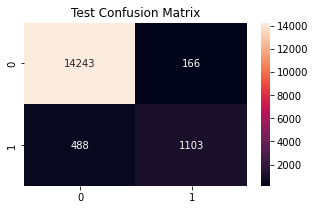

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
%%time

import optuna

def run_lr(trial):
    
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none']),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 1, 100),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 20.0),
        'C': trial.suggest_float('C', 1.0, 100.0),
    }

    if param['penalty'] == 'l1':
        param['l1_ratio'] = 0.0
    elif param['penalty'] == 'elasticnet':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 0.0, 1.0)
    elif param['penalty'] == 'l2':
        param['l1_ratio'] = trial.suggest_float('l1_ratio', 1.1, 20.0)
    
    cv_outer=StratifiedKFold(n_splits=5, random_state=state, shuffle=True)
    
    pipe = Pipeline([
        ('prep', TfidfVectorizer(stop_words=stopwords)),
        #('resample', imblearn.combine.SMOTETomek(sampling_strategy=0.7, random_state=state)),
        ('est', LogisticRegression(**param, random_state=state))])       
    
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring='f1_weighted').mean()

CPU times: user 12 µs, sys: 2 µs, total: 14 µs
Wall time: 31 µs


In [ ]:
%%time

study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='LogisticRegression Optuna')
study.optimize(run_lr, n_trials=20, n_jobs=-1)

[I 2022-05-23 18:28:39,853] A new study created in memory with name: LogisticRegression Optuna
[I 2022-05-23 18:29:16,914] Trial 1 finished with value: 0.9536367496749136 and parameters: {'penalty': 'l2', 'solver': 'saga', 'max_iter': 6, 'l1_ratio': 6.542112567632337, 'C': 84.17683209003077}. Best is trial 1 with value: 0.9536367496749136.
[I 2022-05-23 18:29:27,234] Trial 0 finished with value: 0.9463463000726835 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'max_iter': 86, 'l1_ratio': 7.17517883005266, 'C': 43.54552045846555}. Best is trial 1 with value: 0.9536367496749136.
[W 2022-05-23 18:29:44,747] Trial 2 failed, because the objective function returned nan.
[W 2022-05-23 18:29:54,694] Trial 3 failed, because the objective function returned nan.
[W 2022-05-23 18:30:16,181] Trial 4 failed, because the objective function returned nan.
[I 2022-05-23 18:31:11,420] Trial 5 finished with value: 0.9516558616623028 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'max_iter'

CPU times: user 40min 21s, sys: 4min 11s, total: 44min 33s
Wall time: 28min 3s


In [ ]:
study.best_params

{'C': 30.74019578086583,
 'l1_ratio': 13.589801140159302,
 'max_iter': 34,
 'penalty': 'none',
 'solver': 'lbfgs'}

In [ ]:
study.best_value

0.9534654343212683

In [ ]:
study.best_params_2 = {'C': 50,
 'l1_ratio': 12,
 'max_iter': 5,
 'solver': 'saga'}

In [ ]:
study.best_params_3 = {'C': 50,
 'l1_ratio': 15,
 'max_iter': 5,
 'penalty': 'l1',
 'solver': 'saga'}

In [ ]:
%%time
# обучаем и тестируем модель LogisticRegression на TF-IDF

lr = LogisticRegression(**study.best_params_3, random_state=state).fit(tf_idf_train, y_train)
y_pred = lr.predict(tf_idf_test)
# print('F1 на кроссвалидации:', cross_val_score(svc, tf_idf_train, y_train, cv=5, scoring='f1').mean())
print('Accuracy:', lr.score(tf_idf_train, y_train))
print('F1 на тестовой:', f1_score(y_test, y_pred))

Accuracy: 0.973625
F1 на тестовой: 0.7760989010989011
CPU times: user 18.1 s, sys: 18.8 ms, total: 18.1 s
Wall time: 18.1 s


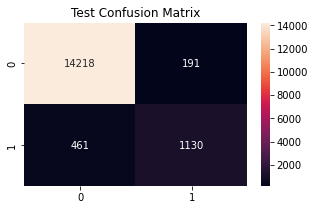

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

Подбор порога классификации

In [ ]:
proba_one_X_test = lr.predict_proba(tf_idf_test)[:,1]
treshold_best, f1_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):
    y_pred = proba_one_X_test > treshold
    f1 = f1_score(y_test, y_pred)
    if f1 > f1_best:
        f1_best = f1
        treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('F1 при подборе порога:', f1_best)

Оптимальный порог классификации: 0.51
F1 при подборе порога: 0.7767057201929704


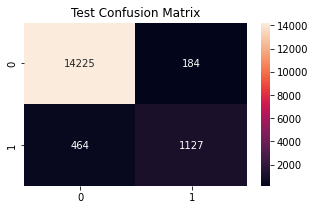

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = proba_one_X_test > treshold_best
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
%%time

import optuna
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

def run_rfc(trial):
    
    param = {
        'max_depth': trial.suggest_int("max_depth", 2, 50, log=True),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 5, 50),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
    }

    cv_outer=StratifiedKFold(n_splits=4, random_state=state, shuffle=True)
    
    pipe = Pipeline([
        ('prep', TfidfVectorizer(stop_words=stopwords, min_df=10)),
        ('est', RandomForestClassifier(**param, random_state=state))])       
    
    return cross_val_score(pipe, X_train, y_train, cv=cv_outer, scoring='f1_weighted').mean()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 18 ms, sys: 0 ns, total: 18 ms
Wall time: 17.7 ms


In [ ]:
%%time

study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=0), 
                            study_name='Random Forest Classifier Optuna')
study.optimize(run_rfc, n_trials=20, n_jobs=-1)

[I 2022-05-23 17:48:13,704] A new study created in memory with name: Random Forest Classifier Optuna
[I 2022-05-23 17:48:23,401] Trial 19 finished with value: 0.8500931646502248 and parameters: {'max_depth': 10, 'min_samples_leaf': 12, 'class_weight': None}. Best is trial 13 with value: 0.877202002992176.
[I 2022-05-23 17:49:01,130] Trial 1 finished with value: 0.8574844545008118 and parameters: {'max_depth': 18, 'min_samples_leaf': 13, 'class_weight': None}. Best is trial 1 with value: 0.8574844545008118.
[I 2022-05-23 17:49:05,158] Trial 0 finished with value: 0.8582631594899187 and parameters: {'max_depth': 23, 'min_samples_leaf': 38, 'class_weight': None}. Best is trial 0 with value: 0.8582631594899187.
[I 2022-05-23 17:49:28,135] Trial 2 finished with value: 0.7466720332134592 and parameters: {'max_depth': 2, 'min_samples_leaf': 23, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8582631594899187.
[I 2022-05-23 17:49:55,223] Trial 4 finished with value: 0.84967305491339

CPU times: user 10min 59s, sys: 5.29 s, total: 11min 4s
Wall time: 7min 37s


In [ ]:
study.best_params

{'class_weight': None, 'max_depth': 50, 'min_samples_leaf': 40}

In [ ]:
study.best_value

0.8852373910151559

In [ ]:
%%time
# обучаем и тестируем модель Random Forest Classifier на TF-IDF

rfc = RandomForestClassifier(**study.best_params, random_state=state).fit(tf_idf_train, y_train)
y_pred = rfc.predict(tf_idf_test)
# print('F1 на кроссвалидации:', cross_val_score(svc, tf_idf_train, y_train, cv=5, scoring='f1').mean())
print('Accuracy:', rfc.score(tf_idf_train, y_train))
print('F1 на тестовой:', f1_score(y_test, y_pred))

Accuracy: 0.911671875
F1 на тестовой: 0.2535675082327113
CPU times: user 12.7 s, sys: 58.7 ms, total: 12.7 s
Wall time: 15.7 s


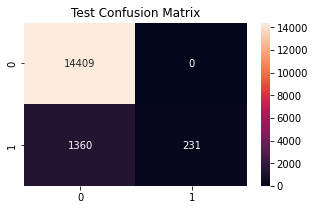

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
proba_one_X_test = rfc.predict_proba(tf_idf_test)[:,1]
treshold_best, f1_best = 0, 0

for treshold in np.arange(0, 0.9, 0.01):
    y_pred = proba_one_X_test > treshold
    f1 = f1_score(y_test, y_pred)
    if f1 > f1_best:
        f1_best = f1
        treshold_best = treshold

print('Оптимальный порог классификации:', treshold_best)
print('F1 при подборе порога:', f1_best)

print('Оптимальный порог классификации:', treshold_best)
print('F1 при подборе порога:', f1_best)

Оптимальный порог классификации: 0.18
F1 при подборе порога: 0.7218390804597702


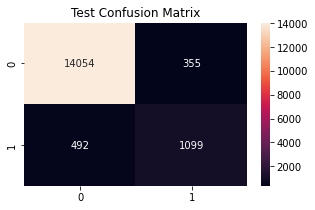

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = proba_one_X_test > treshold_best
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

Сравнение результата с константной моделью классификатора

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier().fit(tf_idf_train, y_train)
y_pred = clf.predict(tf_idf_test)
print('Accuracy:', clf.score(tf_idf_train, y_train))
print('F1 на тестовой:', f1_score(y_test, y_pred))

Accuracy: 0.897953125
F1 на тестовой: 0.0


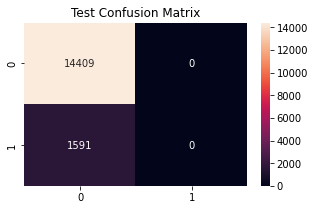

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

Обучаем и тестируем модель CatBoost с дефолтными настройками на лемматизированных данных

In [ ]:
%%time

cat = CatBoostClassifier(random_state=12345, 
                         # task_type='GPU'
                         )
cat.fit(pd.DataFrame(X_train), y_train, text_features=['lemm_text'], verbose=100)
y_pred = cat.predict(pd.DataFrame(X_test))
print('Accuracy:', cat.score(pd.DataFrame(X_train), y_train))
print('F1 на тестовой:', f1_score(y_test, y_pred))

Learning rate set to 0.060838
0:	learn: 0.6087862	total: 387ms	remaining: 6m 26s
100:	learn: 0.1339075	total: 33s	remaining: 4m 53s
200:	learn: 0.1219943	total: 1m 6s	remaining: 4m 22s
300:	learn: 0.1150271	total: 1m 38s	remaining: 3m 49s
400:	learn: 0.1094526	total: 2m 11s	remaining: 3m 16s
500:	learn: 0.1050668	total: 2m 43s	remaining: 2m 43s
600:	learn: 0.1011957	total: 3m 16s	remaining: 2m 10s
700:	learn: 0.0978619	total: 3m 48s	remaining: 1m 37s
800:	learn: 0.0948402	total: 4m 21s	remaining: 1m 4s
900:	learn: 0.0922343	total: 4m 53s	remaining: 32.3s
999:	learn: 0.0898604	total: 5m 25s	remaining: 0us
Accuracy: 0.973796875
F1 на тестовой: 0.7782869228057807
CPU times: user 9min 40s, sys: 1min 9s, total: 10min 49s
Wall time: 5min 37s


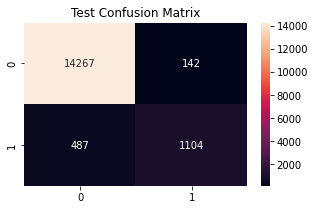

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Test Confusion Matrix')
plt.show()

In [4]:
pd.DataFrame({'model_name': ['CatBoost Classifier', 'Linear SVC', 'Logistic Regression', 'RandomForest Classifier', 'Dummy Classifier'], 
              'f1_score': [0.778, 0.771, 0.777, 0.722, 0.000]}).sort_values('f1_score')

,model_name,f1_score
4,Dummy Classifier,0.000
3,RandomForest Classifier,0.722
1,Linear SVC,0.771
2,Logistic Regression,0.777
0,CatBoost Classifier,0.778


## Выводы

1. Были рассмотрены методы определения тональности текстов по методам мешка слов TF-IDF и Word2vec с добавлеием N-gramm, а также с помощью нейросети BERT с лемматизацией и токенизацией
2. Целевого значения F1 = 0.75 удалось добиться на методе мешка слов с TF-IDF с применением модели на алгоритме Linear Support Vector Classification (классификация линейных опорных векторов)
3. Метод с BERT очень требователен к вычислительным мощностям и объему оперативной памяти, при выделенном сэмпле размера 100 000 получить приемлемый результат удалось только с помощью подбора порога классификации. Но есть отчетливое понимание, что с ростом объема выборки и увелиичением мешка слов метрика улучшается. 